# Multi-View Human Pose Fusion
This notebook demonstrates the workflow for fusion human pose representations extracted using a 2s-AGCN model. 
The poses are first extracted using mmpose, processed using a 2s-AGCN model, and then fused using a simple fusion method.

In [2]:
from pathlib import Path
import sys 
import numpy as np
from egoexo_dataloader_2 import EgoExoDataset
import os
import torch
import random
from torch.utils.data import DataLoader

sys.path.append(str(Path.cwd().parent))
print(Path.cwd().parent)


/home/thibault/Documents/PhD/training


## Functions


## Import the custom dataset and PyTorch DataLoader
The dataset "\__getitem__" method returns time-synchronized ego and exo views as well as the corresponding skill label.

In [3]:
dataset_path = '/media/thibault/T5 EVO/Datasets/Ego4D/'
train_dataset = EgoExoDataset(dataset_path, os.path.join(dataset_path, 'takes.json'), split = "train", skill=True, get_frames=False, get_pose=False, get_hands_pose=False, frame_rate=3, transform=None)
val_dataset = EgoExoDataset(dataset_path, os.path.join(dataset_path, 'takes.json'), split = "val", skill=True, get_frames=False, get_pose=False, get_hands_pose=False, frame_rate=3, transform=None)

In [4]:
train_data = train_dataset.samples
train_data

[{'take_uid': 'a5e81f20-ea35-4f63-a908-11d89fc1294c',
  'label': 1011,
  'skill': 0,
  'parent_task_id': 1000,
  'ego': '/media/thibault/T5 EVO/Datasets/Ego4D/takes/georgiatech_cooking_01_01_4/frame_aligned_videos/downscaled/448/aria04_214-1.mp4',
  'exo': ['/media/thibault/T5 EVO/Datasets/Ego4D/takes/georgiatech_cooking_01_01_4/frame_aligned_videos/downscaled/448/aria04.mp4',
   '/media/thibault/T5 EVO/Datasets/Ego4D/takes/georgiatech_cooking_01_01_4/frame_aligned_videos/downscaled/448/cam01.mp4',
   '/media/thibault/T5 EVO/Datasets/Ego4D/takes/georgiatech_cooking_01_01_4/frame_aligned_videos/downscaled/448/cam02.mp4',
   '/media/thibault/T5 EVO/Datasets/Ego4D/takes/georgiatech_cooking_01_01_4/frame_aligned_videos/downscaled/448/cam03.mp4',
   '/media/thibault/T5 EVO/Datasets/Ego4D/takes/georgiatech_cooking_01_01_4/frame_aligned_videos/downscaled/448/cam04.mp4']},
 {'take_uid': '3db860b7-a23a-4d9b-a988-4b656a608122',
  'label': 1011,
  'skill': 0,
  'parent_task_id': 1000,
  'ego': '/

## Import the mmpose inference function
This inferencer returns the pose for the given video as a list of 2D keypoints. Additionally, the function returns the confidence score for each keypoint.

In [5]:
from mmpose.apis import MMPoseInferencer
from mmaction.apis import pose_inference, detection_inference


inferencer = MMPoseInferencer('human')

/home/thibault/miniconda3/envs/ego-challenge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/thibault/miniconda3/envs/ego-challenge/lib/python3.12/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
05/09 16:46:21 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
05/09 16:46:21 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a corre

In [6]:
config = Path("/home/thibault/Documents/Code/pckg/mmaction2/configs/skeleton/2s-agcn/2s-agcn_8xb16-bone-u100-80e_ntu60-xsub-keypoint-2d.py")
checkpoint = Path("/home/thibault/Documents/Code/Ego4DChallenge/Scripts/Tests/mmaction/checkpoints/2s-agcn_8xb16-bone-u100-80e_ntu60-xsub-keypoint-2d_20221222-293878b5.pth")


In [7]:
import tempfile
from mmaction.utils import frame_extract

video_path = Path("/media/thibault/T5 EVO/Datasets/Ego4D/takes/cmu_soccer16_4/frame_aligned_videos/downscaled/448/cam02.mp4")


In [8]:
det_config = '/home/thibault/Documents/Code/pckg/mmaction2/demo/demo_configs/faster-rcnn_r50_fpn_2x_coco_infer.py'
det_checkpoint = "/home/thibault/Documents/Code/pckg/mmaction2/checkpoints/faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth"


In [9]:
skeleton_config = "/home/thibault/Documents/Code/pckg/mmaction2/demo/demo_configs/td-hm_hrnet-w32_8xb64-210e_coco-256x192_infer.py"
skeleton_checkpoint = "/home/thibault/Documents/Code/pckg/mmaction2/checkpoints/hrnet_w32_coco_256x192-c78dce93_20200708.pth"

In [10]:
import torch
torch.cuda.empty_cache()

In [11]:
import cv2
import numpy as np
from typing import Callable, Generator, List

def frame_windows(video_path: str,
                  window_size: int,
                  sampling_rate: int = 1
                 ) -> Generator[List[np.ndarray], None, None]:
    """
    Lazily read frames from the video, sampling 1 in every `sampling_rate`,
    and yield lists of up to `window_size` sampled frames.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None
    frames: List[np.ndarray] = []
    raw_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # only keep every `sampling_rate`th frame
        if raw_idx % sampling_rate == 0:
            frames.append(frame)
            if len(frames) == window_size:
                yield frames
                frames = []

        raw_idx += 1

    # leftover sampled frames
    if frames:
        yield frames

    cap.release()

def extract_skeleton(video_path: str,
                     window_size: int = 32,
                     sampling_rate: int = 1,
                     predict: Callable[[List[np.ndarray]], np.ndarray] = None
                    ) -> np.ndarray:
    """
    Process a video in non-overlapping windows to extract per-frame skeletons
    without ever loading the whole video into RAM at once.

    Args:
        video_path: Path to the input video file.
        window_size: Number of frames per chunk.
        predict: Function(frames_list) → np.ndarray of shape
                 (num_frames, num_keypoints, dims).

    Returns:
        skeleton_sequence: np.ndarray of shape
            (total_frames, num_keypoints, dims).
    """
    if predict is None:
        raise ValueError("You must pass in a `predict` function.")
    
    skeleton_chunks = []
    total = 0
    for frames in frame_windows(video_path, window_size, sampling_rate):
        # frames is at most window_size in length
        det_results, _ = detection_inference(det_config, det_checkpoint, frames)
        pose_results, pose_data_samples = pose_inference(skeleton_config, skeleton_checkpoint, frames, det_results)
         # e.g. (len(frames), K, D)
        skeleton_chunks.append(np.array(pose_results))
        total += len(pose_results)
    
    # Concatenate along temporal axis:
    skeleton_sequence = np.concatenate(skeleton_chunks, axis=0)
    assert skeleton_sequence.shape[0] == total
    
    output_json_path = video_path.parent / f"{video_path.name[:-4]}.npy"

    np.save(output_json_path, skeleton_sequence)
    return skeleton_sequence


In [12]:
for sample in train_data:
    for path in sample["exo"]:
        skeleton_sequence = extract_skeleton(path, window_size=128, sampling_rate=3, predict=pose_inference)

Error opening video file /media/thibault/T5 EVO/Datasets/Ego4D/takes/georgiatech_cooking_01_01_4/frame_aligned_videos/downscaled/448/aria04.mp4


ValueError: need at least one array to concatenate

In [14]:
data = np.load("/media/thibault/T5 EVO/Datasets/Ego4D/takes/cmu_soccer16_4/frame_aligned_videos/downscaled/448/cam02.npy", allow_pickle=True)
data[10]["keypoints"].shape

(2, 17, 2)

(-0.5, 795.5, 447.5, -0.5)

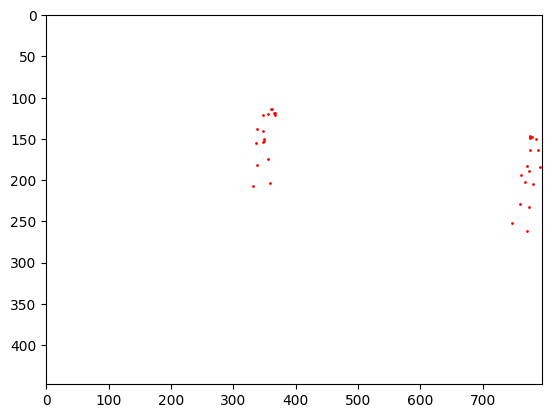

In [16]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

img = np.ones((448,796,3))

for person in data[200]["keypoints"]:
    for point in person:
        plt.scatter(point[0], point[1], color='red', s=1)

ax.imshow(img, aspect='equal')
ax.axis('tight')

In [ ]:
det_results_custom = np.tile(np.array([[0,448,0,796]]), (len(frames),1))
pose_results, pose_data_samples = pose_inference(skeleton_config, skeleton_checkpoint, frame_paths, det_results)

In [ ]:
from mmaction.apis import inference_skeleton, init_recognizer
from mmengine import Config
torch.cuda.empty_cache()
config_path = "/home/thibault/Documents/Code/pckg/mmaction2/configs/skeleton/posec3d/slowonly_r50_8xb16-u48-240e_ntu60-xsub-keypoint.py"
checkpoint_path = "/home/thibault/Documents/Code/pckg/mmaction2/checkpoints/slowonly_r50_8xb16-u48-240e_ntu60-xsub-keypoint_20220815-38db104b.pth" # can be a local path   # you can specify your own picture path

cfg = Config.fromfile(config_path)



# build the model from a config file and a checkpoint file
model = init_recognizer(cfg, checkpoint_path, device="cuda:0")
print(model) # device can be 'cuda:0'
             # test a single image
result = inference_skeleton(model, skeleton_sequence, (796, 448))

In [ ]:
import cv2
import moviepy.editor as mpy
from mmengine import DictAction
from mmengine.utils import track_iter_progress
from mmaction.registry import VISUALIZERS
import mmengine 
import mmcv

FONTFACE = cv2.FONT_HERSHEY_DUPLEX
FONTSCALE = 0.75
FONTCOLOR = (255, 255, 255)  # BGR, white
THICKNESS = 1
LINETYPE = 1

def visualize(pose_config,out_filename, frames, data_samples):
    pose_config = mmengine.Config.fromfile(pose_config)
    visualizer = VISUALIZERS.build(pose_config.visualizer)
    visualizer.set_dataset_meta(data_samples[0].dataset_meta)

    vis_frames = []
    print('Drawing skeleton for each frame')
    for d, f in track_iter_progress(list(zip(data_samples, frames))):
        f = mmcv.imconvert(f, 'bgr', 'rgb')
        visualizer.add_datasample(
            'result',
            f,
            data_sample=d,
            draw_gt=False,
            draw_heatmap=False,
            draw_bbox=True,
            show=False,
            wait_time=0,
            out_file=None,
            kpt_thr=0.3)
        vis_frame = visualizer.get_image()
        cv2.putText(vis_frame, "label", (10, 30), FONTFACE, FONTSCALE,
                    FONTCOLOR, THICKNESS, LINETYPE)
        vis_frames.append(vis_frame)

    vid = mpy.ImageSequenceClip(vis_frames, fps=24)
    vid.write_videofile(out_filename, remove_temp=True)

# Perfom Inference using 2s-AGCN

In [ ]:
pose_config = '/home/thibault/Documents/Code/pckg/mmaction2/demo/demo_configs/td-hm_hrnet-w32_8xb64-210e_coco-256x192_infer.py'
out_filename= 'output.mp4'
visualize(pose_config, out_filename, frames, pose_data_samples)

## Generate pose for all views